In [2]:
print("importing modules")
import os
import sys
import json
import argparse
import numpy as np
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
from PIL import Image
import pandas as pd
import nibabel as nib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenCLIPEmbedder, FrozenOpenCLIPEmbedder2
from generative_models.sgm.models.diffusion import DiffusionEngine
from generative_models.sgm.util import append_dims
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

import utils

# Can run a SLURM job array to train many models with different random seed values
try:
    idx = int(os.environ["SLURM_ARRAY_TASK_ID"])
    seeds = range(10)
    seed = seeds[idx]
    print(f"using random seed {seed} in SLURM job array")
except:
    print("SLURM random seed indices not provided; using random seed = 0")
    seed = 0


if utils.is_interactive():
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 
    
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False)
device = accelerator.device
print("device:",device)

importing modules
SLURM random seed indices not provided; using random seed = 0


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


LOCAL RANK  0
device: cuda


# Data

## New Design

In [3]:
# n_runs = 16
# remove_close_to_MST = False
# remove_random_n = False
# if remove_close_to_MST or remove_random_n:
#     assert remove_close_to_MST != remove_random_n  # don't remove both sets of images

# if remove_random_n:
#     assert train_test_split == 'MST'  # MST images are excluded from the n images removed, so only makes sense if they're not in the training set
#     n_to_remove = 150

In [10]:
if utils.is_interactive():
    sub = "sub-001"
    session = "ses-04"
    # if session == "multi":
    #     ses_list = ["ses-02", "ses-03"]
    train_test_split = 'MST'  # orig
    glmsingle_path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{session}"
    model_name = f"{sub}_{session}_bs24_MST_rishab_{train_test_split}split" # 'testing_MST' 
    print("model_name:", model_name)


model_name: sub-001_ses-04_bs24_MST_rishab_MSTsplit


# Model

In [11]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2 \
                    --model_name={model_name} --subj=1 \
                    --no-blurry_recon --use_prior \
                    --hidden_dim=1024 --n_blocks=4"
    
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

--data_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2                     --model_name=sub-001_ses-04_bs24_MST_rishab_MSTsplit --subj=1                     --no-blurry_recon --use_prior                     --hidden_dim=1024 --n_blocks=4
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="will load ckpt for model found in ../train_logs/model_name",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/mindeyev2_dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=False,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=2048,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--seq_len",type=int,default=1,
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--glmsingle_path",type=str,
)
parser.add_argument(
    "--remove_random_n",action=argparse.BooleanOptionalAction,default=False,
)
# parser.add_argument(
#     "--train_test_split",type=str,
# )

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# make output directory
os.makedirs("evals",exist_ok=True)
os.makedirs(f"evals/{model_name}",exist_ok=True)

In [13]:
eval_dir = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/evals/{model_name}"
if remove_random_n:
    imgs_to_remove = np.load(f"{eval_dir}/imgs_to_remove.npy")
train_image_indices = np.load(f"{eval_dir}/train_image_indices.npy")
test_image_indices = np.load(f"{eval_dir}/test_image_indices.npy")
images = torch.Tensor(np.load(f"{eval_dir}/images.npy"))
vox = torch.Tensor(np.load(f"{eval_dir}/vox.npy"))

In [14]:
images.shape

torch.Size([1000, 3, 224, 224])

In [7]:
test_data = torch.utils.data.TensorDataset(torch.tensor(test_image_indices))
subj_list = [subj]
subj = subj_list[0]
test_dl = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

Loaded test dl for subj1!



In [8]:
test_voxels, test_images = None, None
for test_i, behav in enumerate(test_dl):
    behav = behav[0]

    if behav.ndim>1:
        test_image = images[behav[:,0].long().cpu()].to(device)
        test_vox = vox[behav.long().cpu()].mean(1)
    else:
        test_image = images[behav.long().cpu()].to(device)
        test_vox = vox[behav.long().cpu()]
    
    if test_voxels is None:
        test_voxels = test_vox
        test_images = test_image
    else:
        test_voxels = torch.vstack((test_voxels, test_vox))
        test_images = torch.vstack((test_images, test_image))

print(test_i, len(test_voxels), len(test_images))

0 300 300


In [9]:
num_voxels_list = []
num_voxels_list.append(test_voxels.shape[-1])

In [10]:
## USING OpenCLIP ViT-bigG ###
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder

try:
    print(clip_img_embedder)
except:
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",
        version="laion2b_s39b_b160k",
        output_tokens=True,
        only_tokens=True,
    )
    clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

In [11]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len=1): 
        super(RidgeRegression, self).__init__()
        self.seq_len = seq_len
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx=0):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(self.seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression(num_voxels_list, out_features=hidden_dim)
utils.count_params(model.ridge)
utils.count_params(model)

from functools import partial
from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=1, n_blocks=n_blocks, drop=.15, 
                 clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
        if clip_scale>0:
            self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)
            
    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
        
    def forward(self, x):
        # make empty tensors
        c,b = torch.Tensor([0.]), torch.Tensor([[0.],[0.]])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        if clip_scale>0:
            c = self.clip_proj(backbone)
        
        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim)
utils.count_params(model.backbone)
utils.count_params(model)

if use_prior:
    from models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 6
    dim_head = 52
    heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
    timesteps = 100

    prior_network = VersatileDiffusionPriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )

    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
    )
    
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)

param counts:
2,667,520 total
2,667,520 trainable
param counts:
2,667,520 total
2,667,520 trainable
param counts:
453,360,280 total
453,360,280 trainable
param counts:
456,027,800 total
456,027,800 trainable
param counts:
259,865,216 total
259,865,200 trainable
param counts:
715,893,016 total
715,893,000 trainable


In [24]:
# Load pretrained model ckpt
tag='last'
outdir = os.path.abspath(f'/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/train_logs/{model_name}')
print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
print(f"hidden_dim = {hidden_dim}")
checkpoint = torch.load(outdir+f'/{tag}.pth', map_location='cpu')
state_dict = checkpoint['model_state_dict']

# Print the keys (layer names) and parameter shapes of saved+current model, use for debugging in case model_state_dict errors
# for key, value in state_dict.items():
#     print(f"Saved model: {key} -> {value.shape}")
# curr_state_dict = model.state_dict()
# for key, value in curr_state_dict.items():
#     print(f"Current model: {key} -> {value.shape}")

model.load_state_dict(state_dict, strict=True)
del checkpoint
print("ckpt loaded!")


---loading /scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/train_logs/sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_1/last.pth ckpt---

hidden_dim = 1024
Saved model: ridge.linears.0.weight -> torch.Size([1024, 2604])
Saved model: ridge.linears.0.bias -> torch.Size([1024])
Saved model: backbone.mixer_blocks1.0.0.weight -> torch.Size([1024])
Saved model: backbone.mixer_blocks1.0.0.bias -> torch.Size([1024])
Saved model: backbone.mixer_blocks1.0.1.0.weight -> torch.Size([1024, 1024])
Saved model: backbone.mixer_blocks1.0.1.0.bias -> torch.Size([1024])
Saved model: backbone.mixer_blocks1.0.1.3.weight -> torch.Size([1024, 1024])
Saved model: backbone.mixer_blocks1.0.1.3.bias -> torch.Size([1024])
Saved model: backbone.mixer_blocks1.1.0.weight -> torch.Size([1024])
Saved model: backbone.mixer_blocks1.1.0.bias -> torch.Size([1024])
Saved model: backbone.mixer_blocks1.1.1.0.weight -> torch.Size([1024, 1024])
Saved model: backbone.mixer_blocks1.1.1.0.bias -> torch.Size([1024])
Sa

In [13]:
# prep unCLIP
config = OmegaConf.load("/scratch/gpfs/ri4541/MindEyeV2/src/generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38

diffusion_engine = DiffusionEngine(network_config=network_config,
                       denoiser_config=denoiser_config,
                       first_stage_config=first_stage_config,
                       conditioner_config=conditioner_config,
                       sampler_config=sampler_config,
                       scale_factor=scale_factor,
                       disable_first_stage_autocast=disable_first_stage_autocast)
# set to inference
diffusion_engine.eval().requires_grad_(False)
diffusion_engine.to(device)

ckpt_path = '/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/unclip6_epoch0_step110000.ckpt' 
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])

batch={"jpg": torch.randn(1,3,1,1).to(device), # jpg doesnt get used, it's just a placeholder
      "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(device)}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(device)
print("vector_suffix", vector_suffix.shape)

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
vector_suffix torch.Size([1, 1024])


In [13]:
# setup text caption networks
from transformers import AutoProcessor, AutoModelForCausalLM
from modeling_git import GitForCausalLMClipEmb
# processor = AutoProcessor.from_pretrained("microsoft/git-large-coco")
# clip_text_model = GitForCausalLMClipEmb.from_pretrained("microsoft/git-large-coco")
processor = AutoProcessor.from_pretrained("/scratch/gpfs/ri4541/real_time_mindEye2/coco")
clip_text_model = GitForCausalLMClipEmb.from_pretrained("/scratch/gpfs/ri4541/real_time_mindEye2/coco")

clip_text_model.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
clip_text_model.eval().requires_grad_(False)
clip_text_seq_dim = 257
clip_text_emb_dim = 1024

class CLIPConverter(torch.nn.Module):
    def __init__(self):
        super(CLIPConverter, self).__init__()
        self.linear1 = nn.Linear(clip_seq_dim, clip_text_seq_dim)
        self.linear2 = nn.Linear(clip_emb_dim, clip_text_emb_dim)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.linear1(x)
        x = self.linear2(x.permute(0,2,1))
        return x
        
clip_convert = CLIPConverter()
state_dict = torch.load("bigG_to_L_epoch8.pth", map_location='cpu')['model_state_dict']
clip_convert.load_state_dict(state_dict, strict=True)
clip_convert.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
del state_dict

In [14]:
# get all reconstructions
model.to(device)
model.eval().requires_grad_(False)

all_blurryrecons = None
all_images = None
all_recons = None
all_predcaptions = []
all_clipvoxels = None
all_prior_out = None
all_backbones = None

minibatch_size = 32
num_samples_per_image = 1
plotting = False

with torch.no_grad():
    for batch in tqdm(range(0,len(test_images),minibatch_size)):
        start_time = time.time() 

        image = test_images[batch:batch+minibatch_size]
        voxel = test_voxels[batch:batch+minibatch_size].unsqueeze(1).to(device)

        # Save ground truth images
        if all_images is None:
            all_images = image
        else:
            all_images = torch.vstack((all_images, image))
        
        voxel_ridge = model.ridge(voxel,0)
        backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)
                
        # Save retrieval submodule outputs
        if clip_scale>0:
            if all_clipvoxels is None:
                all_clipvoxels = clip_voxels.cpu()
            else:
                all_clipvoxels = torch.vstack((all_clipvoxels, clip_voxels.cpu()))
                
        # Feed voxels through OpenCLIP-bigG diffusion prior
        prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                        text_cond = dict(text_embed = backbone), 
                        cond_scale = 1., timesteps = 20).cpu()
        
        if all_prior_out is None:
            all_prior_out = prior_out
        else:
            all_prior_out = torch.vstack((all_prior_out, prior_out))

        pred_caption_emb = clip_convert(prior_out.to(device).float())
        generated_ids = clip_text_model.generate(pixel_values=pred_caption_emb, max_length=20)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
        all_predcaptions = np.hstack((all_predcaptions, generated_caption))
        print(generated_caption)
        
        # Feed diffusion prior outputs through unCLIP
        if plotting:
            jj=-1
            fig, axes = plt.subplots(1, 12, figsize=(10, 4))

        for i in range(len(voxel)):
            samples = utils.unclip_recon(prior_out[[i]],
                             diffusion_engine,
                             vector_suffix,
                             num_samples=num_samples_per_image)
            if all_recons is None:
                all_recons = samples.cpu()
            else:
                all_recons = torch.vstack((all_recons, samples.cpu()))
                
            if plotting:  
                jj+=1
                axes[jj].imshow(utils.torch_to_Image(image[i]))
                axes[jj].axis('off')
                jj+=1
                axes[jj].imshow(utils.torch_to_Image(samples.cpu()[0]))
                axes[jj].axis('off')
        
        plt.show()

        print(model_name)
        # err # dont actually want to run the whole thing with plotting=True

# resize outputs before saving
imsize = 256
all_images = transforms.Resize((imsize,imsize))(all_images).float()
all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
if blurry_recon: 
    all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()
        
## Saving ##
if not os.path.exists(eval_dir):
    os.mkdir(eval_dir)

# if "MST" in model_name:
#     np.save(f"{eval_dir}/MST_ID.npy", MST_ID)
torch.save(all_images.cpu(),f"{eval_dir}/all_images.pt")

# repeats_in_test = []
# for p in pairs:
#     if p[0] in test_image_indices:
#         repeats_in_test.append(p)
        
# repeats_in_test = np.array(repeats_in_test)

# torch.save(test_image_indices, f"{eval_dir}/test_image_indices.pt")
# torch.save(repeats_in_test, f"{eval_dir}/repeats_in_test.pt")
torch.save(all_recons,f"{eval_dir}/all_recons.pt")
if clip_scale>0:
    torch.save(all_clipvoxels,f"{eval_dir}/all_clipvoxels.pt")
torch.save(all_prior_out,f"{eval_dir}/all_prior_out.pt")
torch.save(all_predcaptions,f"{eval_dir}/all_predcaptions.pt")
print(f"saved {model_name} outputs!")

  0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a kitchen with a lot of furniture.', 'a large group of people.', 'a small room with a lot of furniture.', 'a clock on a building', 'a train is parked on the tracks.', 'a white wall', 'a dog is standing on a leash.', 'a kitchen with a stove and a stove.', 'a small room with a lot of stuff on it.', 'a living room with a couch, chair, and television.', 'a room with a lot of furniture.', 'a train is parked on the tracks.', 'a room with a lot of furniture.', 'a large blue sky with a few clouds', 'a room with a view.', 'a room with a lot of furniture.', 'a large area of grass.', 'a couple of animals that are standing in the grass.', 'a woman standing in a room.', 'a large wooden table.', 'a group of people standing around each other.', 'a kitchen with a counter and a refrigerator.', 'a cat sitting on a table.', 'a large building with a lot of windows.', 'a train is parked on the tracks.', 'a herd of elephants grazing.', 'a building with a clock on it.', 'a group of birds flying around.', '

/home/ri4541/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ri4541/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 10%|█         | 1/10 [02:27<22:04, 147.16s/it]

sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a kitchen with a stove and a refrigerator.', 'a table with a plate of food on it', 'a table with a bunch of items on it', 'a kitchen with a microwave and a microwave.', 'a table with a bunch of items on it', 'a house with a door open.', 'a white wall with a mirror on it.', 'a room with a lot of furniture.', 'a small room with a lot of furniture.', 'a room with a view.', 'a room with a table and a chair', 'a boat on a lake with a boat in the background.', 'a large tree with a lot of branches.', "a close up of a person's head", 'a man riding a skateboard on top of a hill.', 'a man riding a horse on a dirt road.', 'a large area of water.', 'a bathroom with a sink and a mirror.', 'a table with a bunch of food on it', 'a street with a lot of traffic.', 'a large room with a lot of furniture.', 'a building with a clock on it.', 'a pair of glasses on a table.', 'a large area with a lot of trees.', 'a large building with a clock on it.', 'a giraffe standing in a field.', 'a train is parked on

 20%|██        | 2/10 [04:54<19:36, 147.11s/it]

sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a kitchen with a counter top.', 'a large piece of wood.', 'a kitchen with a counter and a table', 'a plate of food with a fork.', 'a kitchen with a stove and a refrigerator.', 'a bunch of different types of food', 'a large white building.', 'a table with a bunch of food on it', 'a train is driving down the tracks.', 'a plate of food with a fork.', 'a clock tower with a tower in the background.', 'a long fence.', 'a desk with a keyboard and a mouse', 'a train is driving through a tunnel.', 'a plate of food with a knife.', 'a tree with a lot of leaves.', 'a close up of a plant', "a close up of a person's head", 'a building with a clock on it.', 'a close up of a person', 'a plane is flying in the sky.', 'a close up of a plant', 'a man standing on a tennis court.', 'a woman holding a tennis racket.', 'a large building with a lot of windows.', 'a horse standing on top of a grass covered field.', 'a clock tower with a clock on it.', 'a table with a glass top and a table with a plate on it.

 30%|███       | 3/10 [07:20<17:06, 146.71s/it]

sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a room with a lot of furniture.', 'a large area of sand with a beach and a beach.', 'a tall building with a clock on it.', 'a couple of dogs that are sitting down.', 'a woman standing on a field.', 'a man standing in front of a wall.', 'a large building with a clock on it.', 'a bathroom with a sink and a toilet.', 'a group of people on a field.', 'a group of people standing on top of a field.', 'a building with a lot of windows.', 'a small kitchen with a lot of stuff on it', 'a large building with a lot of windows.', 'a room with a lot of furniture.', 'a room with a view', 'a room with a view', 'a bird is sitting on a tree.', 'a large grassy area.', 'a man standing in front of a building.', 'a large room with a table and chairs.', 'a large building with a clock on it.', 'a bowl of fruit with a bowl of fruit on it.', 'a large airport with a lot of planes.', 'a large tree with a few leaves.', 'a table with a bunch of food on it', 'a plate of food with a fork.', 'a building with a clock

 40%|████      | 4/10 [09:47<14:40, 146.69s/it]

sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large wooden building.', 'a close up of a plant', 'a large building with a lot of windows.', 'a table with a plate of food on it', 'a building with a clock on it.', 'a bathroom with a toilet and a sink.', 'a boat is parked on the side of the road.', 'a white wall', 'a bathroom with a toilet and sink.', 'a desk with a laptop on it', 'a child is standing on a small hill.', 'a couple of animals that are standing in the grass.', 'a skier is skiing down a hill.', 'a large group of animals.', 'a person standing on a beach.', 'a room with a view', 'a large room with a lot of furniture.', 'a bird flying in the sky.', 'a large area of grass.', 'a bus parked on the side of a road.', 'a small bird is standing on a small bird.', 'a large area with a lot of people walking around.', 'a building with a tower and a clock.', 'a kitchen with a lot of furniture.', 'a large building with a lot of windows.', 'a kitchen with a counter and a refrigerator.', 'a large tree.', 'a large grassy area.', 'a lar

 50%|█████     | 5/10 [12:15<12:15, 147.15s/it]

sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a city street with a lot of traffic.', 'a room with a lot of furniture.', 'a plant with a lot of leaves.', 'a large white airplane.', 'a large wooden table.', 'a bird is standing on a branch.', 'a small room with a lot of furniture.', 'a person on a surfboard in the water.', 'a table with a bunch of chairs', 'a man riding a snowboard down a snow covered slope.', 'a clock on a building.', 'a white table with a plate on it', 'a boat is parked on the side of the road.', 'a large building with a lot of windows.', 'a picture of a tree.', 'a room with a lot of furniture.', 'a building with a clock on it', 'a surfer on a surfboard in the ocean.', 'a large blue and white building.', 'a table with a bunch of items on it', 'a building with a lot of windows.', 'a large building with a lot of windows.', 'a table with a bunch of chairs', 'a kitchen with a lot of furniture.', 'a kitchen with a lot of furniture.', 'a large body of water.', 'a kitchen with a stove and a sink.', 'a table with a bunch

 60%|██████    | 6/10 [14:42<09:48, 147.12s/it]

sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a train is driving through a train station.', 'a group of people standing around a field.', 'a bus parked next to a bus.', 'a large building with a clock on it.', 'a kitchen with a lot of counter space', 'a train is parked on the side of the road.', 'a boat on a lake with a large boat in the background.', 'a large building with a lot of windows.', 'a small tree with a few leaves.', 'a plate of food', 'a close up of a person', 'a beach with a bunch of people on it', 'a large group of people.', 'a group of people on a field.', 'a room with a view', 'a large truck is parked in front of a building.', 'a man riding a surfboard on top of a wave.', 'a clock tower with a clock on it.', 'a clock tower with a tower in the background.', 'a man on a snowboard in the air.', 'a building with a clock on it.', 'a street with a car and a bridge', 'a room with a view', 'a large building with a clock on it.', 'a large white bird.', 'a clock on a building', 'a large tree', 'a large room with a lot of fu

 70%|███████   | 7/10 [17:09<07:21, 147.24s/it]

sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a bunch of different types of food', 'a large area with a lot of people around it.', 'a large body of water.', 'a large body of water.', 'a white and black photo of a small house.', 'a close up of a bird on a tree', 'a boat is parked on the side of the road.', 'a train is parked on the tracks.', 'a large white and red airplane.', 'a man riding a skateboard down a snow covered slope.', 'a room with a lot of furniture.', 'a train is parked on the tracks.', 'a large white and blue plane.', 'a large building with a lot of windows.', 'a bunch of vegetables', 'a large display of chinese art.', 'a large display of items.', 'a man is standing on a hill.', 'a plate of food', 'a boat on a lake with a dock.', 'a surfer is riding a wave.', 'a large building with a clock on it.', 'a large tower with a clock on it.', 'a large building with a clock on it.', 'a surfer is riding a wave.', 'a room with a couch, chair, and a table.', 'a couple of boats sitting on top of a lush green field.', 'a fire hy

 80%|████████  | 8/10 [19:38<04:55, 147.86s/it]

sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a room with a couch, chairs, and a table.', 'a table with a bunch of food on it', 'a view of a house from the back.', 'a zebra standing on a dirt field.', 'a white and black sign', 'a large building with a lot of windows.', 'a table with a bunch of food on it', 'a close up of a zebra', 'a train is parked on the tracks.', 'a bus parked on the side of a road.', 'a man on a skateboard on a skateboard.', 'a close up of a person', 'a large brown and white bird.', 'a large area with a lot of cars parked.', 'a building with a clock on it.', 'a white wall with a mirror on it', 'a large truck is parked next to a building.', 'a zebra standing in a field.', 'a small area with a lot of grass.', 'a display of items in a room.', 'a vase with flowers and a vase with flowers.', 'a large building with a clock on it.', 'a building with a clock on it.', 'a tennis player is holding a racket.', 'a large tower with a clock on it.', 'a table with a bunch of items on it', 'a plant with a flower in it.', 'a 

 90%|█████████ | 9/10 [22:07<02:28, 148.25s/it]

sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a street light with a red light', 'a train is on the tracks.', 'a boat is parked on the side of a lake.', 'a large body of water.', 'a table with a bunch of food on it', 'a clock tower with a tower in the background.', "a close up of a person's head", 'a white bowl with a black bowl in it.', 'a street light with a red light', 'a street with a traffic light and a street with a sign.', 'a small table with a clock on it.', 'a boat on a body of water']


100%|██████████| 10/10 [23:04<00:00, 138.44s/it]

sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0



/home/ri4541/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


saved sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0 outputs!


In [15]:
# # imsize = 256
# # all_images = transforms.Resize((imsize,imsize))(all_images).float()
# # all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
# # if blurry_recon: 
# #     all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()

# eval_dir = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/evals/{model_name}"
# ## Saving ##
# if not os.path.exists(eval_dir):
#     os.mkdir(eval_dir)

# # # if "MST" in model_name:
# #     # np.save(f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/evals/{model_name}/{model_name}_MST_ID.npy", MST_ID)
# torch.save(all_images.cpu(),f"{eval_dir}/all_images.pt")
# torch.save(all_recons,f"{eval_dir}/all_recons.pt")
# if clip_scale>0:
#     torch.save(all_clipvoxels,f"{eval_dir}/all_clipvoxels.pt")
# torch.save(all_prior_out,f"{eval_dir}/all_prior_out.pt")
# torch.save(all_predcaptions,f"{eval_dir}/all_predcaptions.pt")
# print(f"saved {model_name} outputs!")

In [17]:
all_images.shape

torch.Size([300, 3, 256, 256])

In [18]:
x = torch.permute(all_images, (0,2,3,1))
y = torch.permute(all_recons, (0,2,3,1))

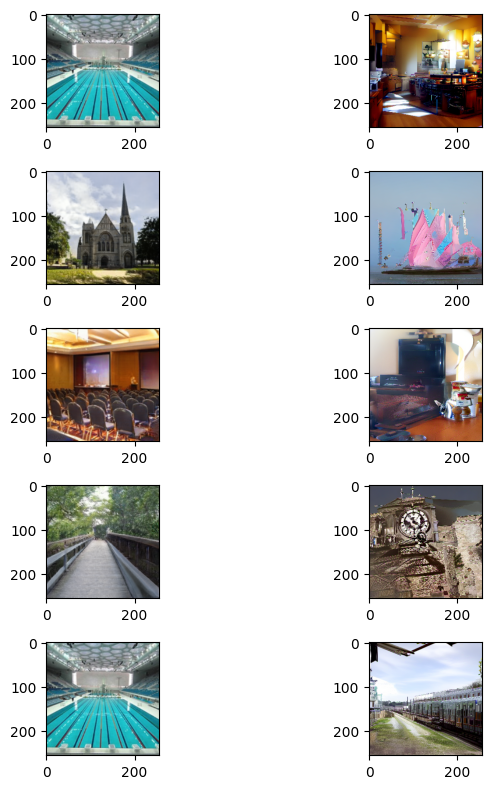

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(8, 8))
for row, _ in enumerate(ax):
    ax[row][0].imshow(x.cpu()[row])
    ax[row][1].imshow(y.cpu()[row])
plt.tight_layout()
plt.show()